In [3]:
!pip install timm

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: gpu


In [7]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
import random
import time
import os
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616]),
])

train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Test samples :", len(test_dataset))

100%|██████████| 170M/170M [00:02<00:00, 67.3MB/s]


Train samples: 50000
Test samples : 10000


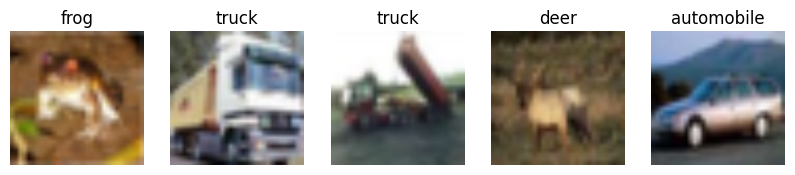

In [11]:
import matplotlib.pyplot as plt

# Class names for CIFAR-10
classes = train_dataset.classes

# Show 5 sample images
plt.figure(figsize=(10, 4))

for i in range(5):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0)  # convert from CxHxW → HxWxC

    # un-normalize the image
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])
    img = img * std + mean

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(classes[label])
    plt.axis("off")

plt.show()


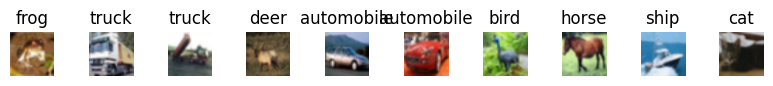

In [13]:
import matplotlib.pyplot as plt

# Class names for CIFAR-10
classes = train_dataset.classes

# Show 5 sample images
plt.figure(figsize=(10, 4))

for i in range(10):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0)

    # un-normalize the image
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])
    img = img * std + mean

    plt.subplot(6, 10, i + 1)
    plt.imshow(img)
    plt.title(classes[label])
    plt.axis("off")

plt.show()


In [14]:
print("Classes:", train_dataset.classes)
print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

# Print image and label information
img, label = train_dataset[0]
print("Image tensor shape:", img.shape)
print("Label value:", label)
print("Label name:", train_dataset.classes[label])


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of training samples: 50000
Number of test samples: 10000
Image tensor shape: torch.Size([3, 224, 224])
Label value: 6
Label name: frog


In [15]:
import math, time, os, copy, random
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.transforms import RandAugment
from tqdm import tqdm


In [16]:
# ---------------------------
# Helpers / Utilities
# ---------------------------
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k / batch_size).item() * 100.0)
        return res


In [17]:
# MixUp
def mixup_data(x, y, alpha=1.0, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [18]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [19]:
# ---------------------------
# Model Components
# ---------------------------
class AddEmbedding(nn.Module):
    def __init__(self, in_ch=3, embed_dim=192):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, embed_dim//2, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(embed_dim//2)
        self.conv2 = nn.Conv2d(embed_dim//2, embed_dim//2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(embed_dim//2)
        self.conv3 = nn.Conv2d(embed_dim//2, embed_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, x):
        B = x.shape[0]
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        B, C, H, W = x.shape
        n = H * W
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        cls_tok = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tok, x], dim=1)
        x = self.norm(x)
        return x, (H, W)


In [20]:
class CLPA_MSA(nn.Module):
    def __init__(self, dim, heads=4, dim_head=48, dropout=0.0, alpha=0.5):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        inner_dim = dim_head * heads
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = dim_head ** -0.5
        self.alpha = alpha
    def forward(self, x, attn_history: List[torch.Tensor]):
        B, N, C = x.shape
        q = self.to_q(x).view(B, N, self.heads, self.dim_head).transpose(1,2)
        k = self.to_k(x).view(B, N, self.heads, self.dim_head).transpose(1,2)
        v = self.to_v(x).view(B, N, self.heads, self.dim_head).transpose(1,2)
        attn_cur = torch.matmul(q, k.transpose(-2,-1)) * self.scale
        attn_cur = F.softmax(attn_cur, dim=-1)
        if attn_history and len(attn_history) > 0:
            stacked = torch.stack(attn_history, dim=0)
            attn_prev = stacked.mean(dim=0)
            attn_blend = self.alpha * attn_prev + (1.0 - self.alpha) * attn_cur
            attn = F.softmax(attn_blend, dim=-1)
        else:
            attn = attn_cur
        out = torch.matmul(attn, v)
        out = out.transpose(1,2).contiguous().view(B, N, -1)
        out = self.to_out(out)
        out = self.dropout(out)
        return out, attn_cur.detach()


In [21]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_mult=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * hidden_mult),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * hidden_mult, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


In [22]:
class LocalityEnhancementBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dw = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.pw = nn.Conv2d(dim, dim, kernel_size=1)
        self.act = nn.GELU()
        self.norm = nn.LayerNorm(dim)
    def forward(self, x, spatial_shape):
        B, N, C = x.shape
        cls, tokens = x[:, :1, :], x[:, 1:, :]
        H, W = spatial_shape
        tokens = tokens.transpose(1,2).reshape(B, C, H, W)
        out = self.dw(tokens)
        out = self.pw(out)
        out = self.act(out)
        out = out.reshape(B, C, -1).transpose(1,2)
        out = torch.cat([cls, out], dim=1)
        out = self.norm(out)
        return out


In [24]:
class AddVitBlock_CLPA(nn.Module):
    def __init__(self, dim, heads=4, mlp_mult=4, dropout=0.0, alpha=0.5):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = CLPA_MSA(dim=dim, heads=heads, dim_head=dim//heads, dropout=dropout, alpha=alpha)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, hidden_mult=mlp_mult, dropout=dropout)
        self.local = LocalityEnhancementBlock(dim)
    def forward(self, x, spatial_shape, attn_history: List[torch.Tensor]):
        x_norm = self.norm1(x)
        attn_out, cur_attn = self.attn(x_norm, attn_history)
        x = x + attn_out
        x = x + self.local(x, spatial_shape)
        x = x + self.ff(self.norm2(x))
        return x, cur_attn


In [23]:
class AddVit_CLPA(nn.Module):
    def __init__(self, image_size=32, in_ch=3, embed_dim=192, depth=6, heads=4, mlp_mult=4, num_classes=10, alpha=0.5, dropout=0.0):
        super().__init__()
        self.embed = AddEmbedding(in_ch=in_ch, embed_dim=embed_dim)
        self.depth = depth
        self.blocks = nn.ModuleList([
            AddVitBlock_CLPA(dim=embed_dim, heads=heads, mlp_mult=mlp_mult, dropout=dropout, alpha=alpha)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
    def forward(self, x):
        B = x.shape[0]
        x, spatial_shape = self.embed(x)
        attn_history = []
        cur_atts = []
        for blk in self.blocks:
            x, cur_attn = blk(x, spatial_shape, attn_history)
            attn_history.append(cur_attn)
            cur_atts.append(cur_attn)
        x = self.norm(x)
        cls = x[:, 0]
        logits = self.head(cls)
        return logits, cur_atts


In [25]:
# ---------------------------
# CIFAR-10 Data Loaders + Correct Normalization
# ---------------------------
def get_cifar10_loaders(batch_size=128, num_workers=4, mixup_alpha=0.8):
    # Official CIFAR-10 mean/std
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    train_transform = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        RandAugment(num_ops=2, magnitude=9),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_set  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader


In [26]:
# ---------------------------
# Training / Evaluation
# ---------------------------
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, mixup_alpha=0.8, clip_grad_norm=None):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    criterion = nn.CrossEntropyLoss()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, targets) in pbar:
        images = images.to(device)
        targets = targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(images, targets, alpha=mixup_alpha, device=device)
        optimizer.zero_grad()
        logits, _ = model(inputs)
        loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
        loss.backward()
        if clip_grad_norm:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item() * images.size(0)
        acc1 = accuracy(logits, targets, topk=(1,))[0]
        total_acc += acc1 * images.size(0) / 100.0
        pbar.set_description(f"Epoch {epoch} Loss {loss.item():.4f} Acc {acc1:.2f}")
    n = len(dataloader.dataset)
    return total_loss / n, (total_acc / n) * 100.0


In [27]:
def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Eval"):
            images = images.to(device)
            targets = targets.to(device)
            logits, _ = model(images)
            loss = criterion(logits, targets)
            total_loss += loss.item() * images.size(0)
            total_acc += accuracy(logits, targets, topk=(1,))[0] * images.size(0) / 100.0
    n = len(dataloader.dataset)
    return total_loss / n, (total_acc / n) * 100.0


In [ ]:

# ---------------------------
# Runner
# ---------------------------
def run_training(
    epochs=120,
    batch_size=128,
    lr=3e-4,
    weight_decay=0.05,
    num_workers=4,
    device=None,
    save_dir='./checkpoints',
    alpha=0.5,
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(save_dir, exist_ok=True)

    # ← CIFAR-10 loaders
    train_loader, test_loader = get_cifar10_loaders(batch_size=batch_size, num_workers=num_workers)

    # ← 10 classes instead of 100
    model = AddVit_CLPA(image_size=32, in_ch=3, embed_dim=192, depth=6, heads=6, mlp_mult=3, num_classes=10, alpha=alpha).to(device)
    print("Model params:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = epochs * len(train_loader)
    def lr_lambda(current_step):
        warmup_steps = int(0.03 * total_steps)
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_acc = 0.0
    best_model = None
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch, mixup_alpha=0.8, clip_grad_norm=1.0)
        val_loss, val_acc = evaluate(model, test_loader, device)
        t1 = time.time()
        print(f"Epoch {epoch} time {t1-t0:.1f}s Train loss {train_loss:.4f} Train acc {train_acc:.2f} | Val loss {val_loss:.4f} Val acc {val_acc:.2f}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            ckpt_path = os.path.join(save_dir, f'best_clpa_addvit_cifar10_epoch{epoch}_acc{val_acc:.2f}.pth')
            torch.save({'epoch': epoch, 'state_dict': best_model, 'val_acc': val_acc}, ckpt_path)
            print(f"Saved best to {ckpt_path}")
    print("Training finished. Best val acc:", best_acc)
    return model, best_acc, train_losses, train_accs, val_losses, val_accs, test_loader

if __name__ == "__main__":
    best = run_training(
        epochs=50,
        batch_size=128,
        lr=3e-4,
        weight_decay=0.05,
        num_workers=4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        save_dir='./checkpoints',
        alpha=0.5,
    )

Model params: 2.76241 M


Eval: 100%|██████████| 79/79 [00:18<00:00,  4.34it/s]

Epoch 1 time 227.8s Train loss 2.1136 Train acc 18.38 | Val loss 1.7317 Val acc 37.61
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch1_acc37.61.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 2 time 226.3s Train loss 1.9244 Train acc 25.81 | Val loss 1.4464 Val acc 50.14
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch2_acc50.14.pth



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]

Epoch 3 time 226.1s Train loss 1.7721 Train acc 28.07 | Val loss 1.3191 Val acc 54.67
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch3_acc54.67.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 4 time 226.5s Train loss 1.6948 Train acc 29.39 | Val loss 1.2211 Val acc 58.47
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch4_acc58.47.pth



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]

Epoch 5 time 226.3s Train loss 1.6623 Train acc 32.72 | Val loss 1.1358 Val acc 62.68
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch5_acc62.68.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 6 time 226.8s Train loss 1.6005 Train acc 32.72 | Val loss 1.0453 Val acc 63.92
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch6_acc63.92.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.39it/s]

Epoch 7 time 226.0s Train loss 1.5865 Train acc 34.84 | Val loss 1.0248 Val acc 67.62
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch7_acc67.62.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 8 time 227.0s Train loss 1.5741 Train acc 37.51 | Val loss 1.0107 Val acc 67.32



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 9 time 226.9s Train loss 1.5367 Train acc 37.90 | Val loss 0.9143 Val acc 69.77
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch9_acc69.77.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 10 time 227.6s Train loss 1.5157 Train acc 35.82 | Val loss 0.8953 Val acc 70.92
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch10_acc70.92.pth



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]

Epoch 11 time 227.0s Train loss 1.4826 Train acc 39.15 | Val loss 0.8806 Val acc 71.24
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch11_acc71.24.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.35it/s]

Epoch 12 time 226.9s Train loss 1.4563 Train acc 39.65 | Val loss 0.7967 Val acc 74.51
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch12_acc74.51.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.34it/s]

Epoch 13 time 227.1s Train loss 1.4482 Train acc 39.40 | Val loss 0.7669 Val acc 75.93
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch13_acc75.93.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 14 time 226.7s Train loss 1.4454 Train acc 41.00 | Val loss 0.7837 Val acc 75.52



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 15 time 226.8s Train loss 1.4218 Train acc 38.63 | Val loss 0.8199 Val acc 75.48



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 16 time 227.1s Train loss 1.3926 Train acc 42.05 | Val loss 0.7915 Val acc 75.33



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]

Epoch 17 time 226.5s Train loss 1.4009 Train acc 39.82 | Val loss 0.7425 Val acc 76.72
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch17_acc76.72.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 18 time 227.2s Train loss 1.3868 Train acc 40.47 | Val loss 0.7285 Val acc 78.78
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch18_acc78.78.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 19 time 227.1s Train loss 1.3916 Train acc 42.89 | Val loss 0.7385 Val acc 78.70



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.34it/s]

Epoch 20 time 227.1s Train loss 1.3833 Train acc 41.50 | Val loss 0.6609 Val acc 80.59
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch20_acc80.59.pth



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]

Epoch 21 time 226.8s Train loss 1.3165 Train acc 41.38 | Val loss 0.6220 Val acc 81.04
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch21_acc81.04.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 22 time 227.0s Train loss 1.2957 Train acc 42.92 | Val loss 0.6897 Val acc 79.21



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 23 time 227.4s Train loss 1.3005 Train acc 41.78 | Val loss 0.6463 Val acc 80.40



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]

Epoch 24 time 227.4s Train loss 1.2791 Train acc 39.58 | Val loss 0.5991 Val acc 82.24
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch24_acc82.24.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 25 time 227.4s Train loss 1.3016 Train acc 43.17 | Val loss 0.5785 Val acc 82.95
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch25_acc82.95.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 26 time 227.0s Train loss 1.3035 Train acc 42.78 | Val loss 0.5871 Val acc 83.67
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch26_acc83.67.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 27 time 227.5s Train loss 1.2867 Train acc 41.26 | Val loss 0.5835 Val acc 83.09



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 28 time 227.2s Train loss 1.2647 Train acc 44.10 | Val loss 0.5533 Val acc 84.09
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch28_acc84.09.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 29 time 227.6s Train loss 1.2514 Train acc 43.85 | Val loss 0.5338 Val acc 84.31
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch29_acc84.31.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 30 time 227.7s Train loss 1.2581 Train acc 45.19 | Val loss 0.5673 Val acc 83.85



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]

Epoch 31 time 227.3s Train loss 1.2365 Train acc 46.44 | Val loss 0.5243 Val acc 85.67
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch31_acc85.67.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 32 time 226.8s Train loss 1.2049 Train acc 44.05 | Val loss 0.5140 Val acc 85.62



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.35it/s]

Epoch 33 time 227.9s Train loss 1.1972 Train acc 47.11 | Val loss 0.5285 Val acc 85.25



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 34 time 227.3s Train loss 1.1979 Train acc 47.21 | Val loss 0.5453 Val acc 85.68
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch34_acc85.68.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 35 time 227.5s Train loss 1.1800 Train acc 46.25 | Val loss 0.5124 Val acc 85.87
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch35_acc85.87.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 36 time 227.3s Train loss 1.1799 Train acc 44.97 | Val loss 0.5074 Val acc 86.33
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch36_acc86.33.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.33it/s]

Epoch 37 time 227.9s Train loss 1.1721 Train acc 47.50 | Val loss 0.5033 Val acc 86.65
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch37_acc86.65.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 38 time 227.7s Train loss 1.1820 Train acc 45.54 | Val loss 0.4745 Val acc 86.69
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch38_acc86.69.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.33it/s]

Epoch 39 time 227.7s Train loss 1.1614 Train acc 45.38 | Val loss 0.4970 Val acc 86.65



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]

Epoch 40 time 227.3s Train loss 1.1568 Train acc 44.49 | Val loss 0.4722 Val acc 87.06
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch40_acc87.06.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 41 time 226.4s Train loss 1.1302 Train acc 46.16 | Val loss 0.4712 Val acc 87.16
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch41_acc87.16.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.39it/s]

Epoch 42 time 227.3s Train loss 1.1804 Train acc 45.84 | Val loss 0.5030 Val acc 87.11



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Epoch 43 time 226.9s Train loss 1.1489 Train acc 47.33 | Val loss 0.4734 Val acc 87.43
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch43_acc87.43.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 44 time 227.3s Train loss 1.1117 Train acc 46.36 | Val loss 0.4612 Val acc 87.44
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch44_acc87.44.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 45 time 227.1s Train loss 1.1457 Train acc 46.42 | Val loss 0.5117 Val acc 87.37



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Epoch 46 time 227.1s Train loss 1.1386 Train acc 47.23 | Val loss 0.4763 Val acc 87.51
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch46_acc87.51.pth



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.39it/s]

Epoch 47 time 227.2s Train loss 1.1496 Train acc 46.08 | Val loss 0.4800 Val acc 87.50



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.36it/s]

Epoch 48 time 226.5s Train loss 1.1816 Train acc 47.74 | Val loss 0.4515 Val acc 87.54
Saved best to ./checkpoints/best_clpa_addvit_cifar10_epoch48_acc87.54.pth



Eval: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]

Epoch 49 time 226.7s Train loss 1.1130 Train acc 45.60 | Val loss 0.4658 Val acc 87.51



Eval: 100%|██████████| 79/79 [00:18<00:00,  4.33it/s]

Epoch 50 time 227.0s Train loss 1.1371 Train acc 45.03 | Val loss 0.4914 Val acc 87.45
Training finished. Best val acc: 87.53999999999999


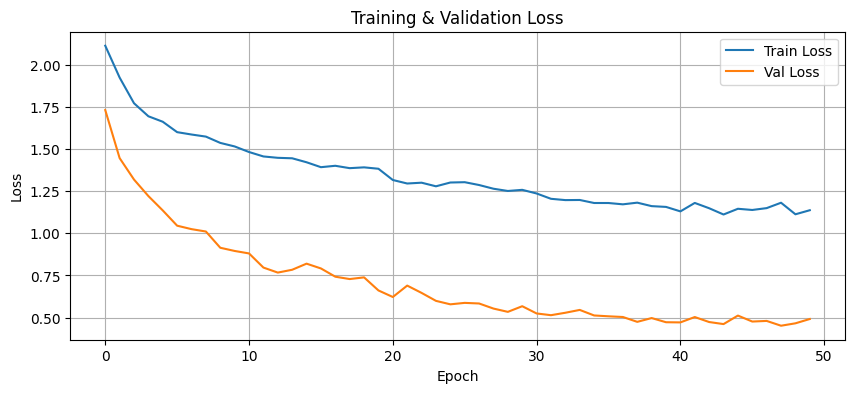

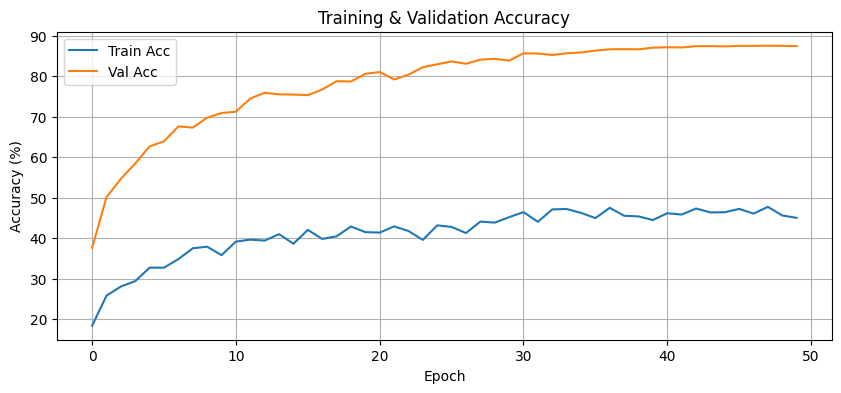

In [2]:
import matplotlib.pyplot as plt

# Unpack results from training
model, best_acc, train_losses, train_accs, val_losses, val_accs, test_loader = best

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
